---
# Gesture Recognition Assignment
---
## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

---

## Objectives
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

---
---

## Table of Content

* [Import the needed libraries](#import)
* [Setup](#setup)
* [Generator](#generator)
* [Model](#model)
    * [Convolutional3D](#conv3d)
        * [Experiment 8](#conv3d_model_8)
        * [Overall Inference](#conv3d_overall_inference)
    * [Convolutional2D + RNN](#conv2d)
        * [Experiment 15](#conv2d_model_15)
        * [Experiment 23](#conv2d_model_23)
        * [Overall Inference](#conv2d_overall_inference)
    * [Transfer Learning + RNN](#transfer_learning)
        * [Experiment 28](#transfer_learning_model_28)
        * [Overall Inference](#transfer_learning_overall_inference)
    * [Additional Experiments](#additional)
        * [Experiment 37](#additional_model_37)
        * [Overall Inference](#additional_overall_inference)        
* [Conclusion](#conclusion)
    * [Load and test the best model](#load_and_test)

---
---

<a id='import'></a>
## Import the needed libraries

In [1]:
import numpy as np
import os
import datetime
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# impo
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, ConvLSTM2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

---
---
<a id='setup'></a>
## Setup

Let's setup few variables needed throughout the notebook.

In [3]:
# Set this to True if using colab platform with drive
use_colab = False
folder_prefix = '/home/datasets/'
data_path = 'Project_data/'

if use_colab:
    # If you are using the data by mounting the google drive, use the following :
    from google.colab import drive
    drive.mount('/content/gdrive')
    folder_prefix = "/content/gdrive/MyDrive/Upgrad/GestureRecognition/"

# Storage folder path
storage = folder_prefix + data_path

In [4]:
# Meta data of train and validation dataset
train_doc = np.random.permutation(open( storage + 'train.csv').readlines())
val_doc = np.random.permutation(open(storage + 'val.csv').readlines())

# train and validation video path
train_path = storage +'train'
val_path = storage +'val'

# batch size
batch_size = 32

# sequence ids - selecting alternate frames from 5 to 25.
seq_idx = range(5,25,2)

# image dimensions
dim_x, dim_y = 120, 120

# input shape for the first layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)

# number of epochs
num_epochs = 50

# number of classes
num_classes = 5

---
---
<a id='generator'></a>
## Generator

Let's create the generator for fetching data to the model.

In [5]:
# Helper function to get one batch data
def get_one_batch_data(source_path, t, batch, batch_size, img_idx, is_augment, remaining_seq=0, image_height=dim_y, image_width=dim_x, debug=False):
    seq_len = remaining_seq if remaining_seq else batch_size
    x = len(img_idx)
    y, z = image_height, image_width

    batch_data = np.zeros((seq_len,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((seq_len,num_classes)) # batch_labels is the one hot representation of the output

    if (is_augment):
        batch_data_aug = np.zeros((seq_len,x,y,z,3)) # Buffer to store augemnted data

    for folder in range(seq_len): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        if(is_augment):
            aug_type = rn.randint(0, 4) #randomly select augmentation type
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = np.array(Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes
            if image.shape[1] > image.shape[0]:
                diff_px = image.shape[1] - image.shape[0]
                crop_start = diff_px//2
                crop_end = crop_start + image.shape[0]
                image = image[:, crop_start:crop_end]
            elif image.shape[0] > image.shape[1]:
                diff_px = image.shape[0] - image.shape[1]
                crop_start = diff_px//2
                crop_end = crop_start + image.shape[1]
                image = image[:, crop_start:crop_end]

            image_resized = np.array(Image.fromarray(image.astype(np.uint8), 'RGB').resize((y,z)))

            batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image

            if(is_augment):
                if(aug_type == 0): # adding gaussian blur
                    image_augmented = np.array(Image.fromarray(image_resized, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                elif(aug_type == 1): # edge Enhancement
                    image_augmented = np.array(Image.fromarray(image_resized, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                elif(aug_type == 2): # sharpening image
                    image_augmented = np.array(Image.fromarray(image_resized, 'RGB').filter(ImageFilter.SHARPEN))
                elif(aug_type == 3): # brightness enhancement
                    image_augmented = np.array(ImageEnhance.Brightness((Image.fromarray(image_resized, 'RGB'))).enhance(1.5))
                elif(aug_type == 4): # enchancing image detailing
                    image_augmented = np.array(Image.fromarray(image_resized, 'RGB').filter(ImageFilter.DETAIL))

                batch_data_aug[folder,idx,:,:,0] = (image_augmented[:,:,0])/255 #normalise and feed in the image
                batch_data_aug[folder,idx,:,:,1] = (image_augmented[:,:,1])/255 #normalise and feed in the image
                batch_data_aug[folder,idx,:,:,2] = (image_augmented[:,:,2])/255 #normalise and feed in the image

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    if (is_augment):
        batch_data=np.concatenate([batch_data,batch_data_aug])
        batch_labels=np.concatenate([batch_labels,batch_labels])

    return (batch_data,batch_labels)

# Generator function to load data in batches
def generator(source_path, folder_list, batch_size, is_train = False, is_augment = False, debug=False, image_height=dim_y, image_width=dim_x, img_idx=seq_idx):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    # Force set augmentation to false if it is not training data
    if is_train == False:
        is_augment = False

    while True:
        t = np.random.permutation(folder_list)

        # calculate the number of full batches
        num_batches = len(t)//batch_size
        for batch in range(num_batches): # we iterate over the number of full batches
            batch_data, batch_labels= get_one_batch_data(source_path, t, batch, batch_size, img_idx, is_augment=is_augment, debug=debug, image_height=image_height, image_width=image_width)
            yield batch_data, batch_labels

        # calculate the remaining data points which are left after full batches
        remaining_seq = len(t)%batch_size
        if (remaining_seq != 0):
            batch_data, batch_labels= get_one_batch_data(source_path, t, num_batches, batch_size, img_idx, is_augment=is_augment, remaining_seq=remaining_seq, debug=debug, image_height=image_height, image_width=image_width)
            yield batch_data, batch_labels

Source path =  /home/datasets/Project_data/train ; batch size = 1


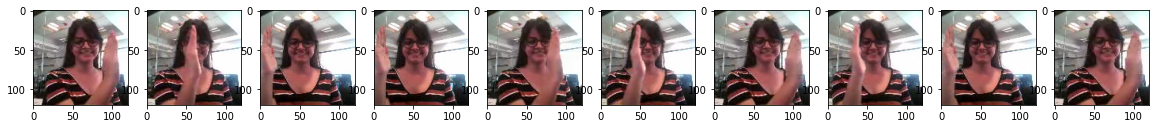

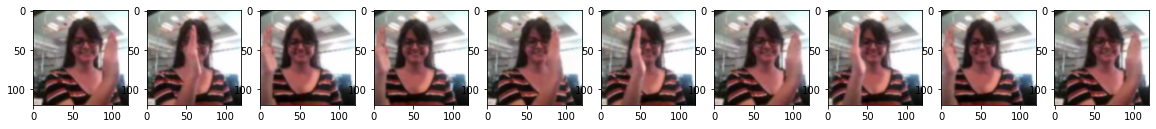

In [9]:
# Test the generator with batch size of 1
sample_gen = generator(train_path, train_doc, 1, is_train = True, is_augment = True, debug = True)
data = next(sample_gen)[0]

# Plot the yielded batch
for idx in range(0,len(data)):
    plt.figure(figsize=(20, len(data[idx])))
    pos = 1
    for n in range(0,len(data[idx])):
        plt.subplot(len(data), len(data[idx]), pos)
        plt.imshow(data[idx][n])
        pos = pos+1
    plt.pause(2)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels).

- The first row corresponds to the raw frames and the second row corresponds to the augmented frames of the same sequence.

---
---

<a id='model'></a>
## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

- Let's define few helper methods to build and train the model as well as visualize the results of the training.

In [6]:
# Visualize the train results
def visualize_train_results(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(acc)   
    axes[0].plot(val_acc)
    axes[0].legend(['Training Accuracy','Validation Accuracy'])

    axes[1].plot(loss)   
    axes[1].plot(val_loss)
    axes[1].legend(['Training Loss','Validation Loss'])

In [7]:
def build_and_train_model(model, is_augment=False, name='model', image_height=dim_y, image_width=dim_x, img_idx=seq_idx, batch_size=batch_size):
    # Compile the model and print the summary
    optimiser = tf.optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print(model.summary())

    # Create the train_generator and the val_generator which will be used in .fit_generator
    train_generator = generator(train_path, train_doc, batch_size, is_train = True, is_augment = is_augment, image_height=image_height, image_width=image_width, img_idx=img_idx)
    val_generator = generator(val_path, val_doc, batch_size, image_height=image_height, image_width=image_width, img_idx=img_idx)
    print("Created generators ....")

    # Create model filepath for storing the weights
    model_name = name + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(model_name):
        os.mkdir(model_name)
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    # Create Keras callbacks
    # Storing model weights
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    # Decay learning rate
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    # Early stop if model is not learning
    earlystop = EarlyStopping( monitor="val_loss", min_delta=0, patience=10, verbose=1)
    callbacks_list = [checkpoint, LR, earlystop]
    print("Created Keras callbacks ....")

    # Calculate steps_per_epoch and validation_steps which are used by `fit_generator` to decide the number of next() calls it need to make.
    num_train_sequences = len(train_doc)*2 if(is_augment==True) else len(train_doc) # Double the length if augmentation is selected
    print('# Training sequences = ', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# Validation sequences = ', num_val_sequences)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    # Let us now fit the model
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                      callbacks=callbacks_list, validation_data=val_generator,
                      validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

    # Visualize training results
    visualize_train_results(history)

    return history

---
---
<a id='conv3d'></a>

## Conv 3D
### Experiment 1:
- Let's start with a simple network.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 120, 120, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 60, 60, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 30, 30, 32)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 64)                3

2024-01-28 05:14:02.858137: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-28 05:14:02.858200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Created Keras callbacks ....
# Training sequences =  663
# Validation sequences =  100
Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/50


2024-01-28 05:14:05.746081: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.9102 - categorical_accuracy: 0.2217Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_1_2024-01-2805_14_02.915687/model-00001-1.91021-0.22172-1.60969-0.21000.h5
21/21 [==============================] - 33s 1s/step - loss: 1.9102 - categorical_accuracy: 0.2217 - val_loss: 1.6097 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.5378 - categorical_accuracy: 0.2941
Epoch 00002: saving model to model_1_2024-01-2805_14_02.915687/model-00002-1.53776-0.29412-1.34187-0.50000.h5
21/21 [==============================] - 26s 1s/step - loss: 1.5378 - categorical_accuracy: 0.2941 - val_loss: 1.3419 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.2676 - categorical_accuracy: 0.4827
Epoch 00003: saving model to model_1_2024-01-2805_14_02.915687/model-00003-1

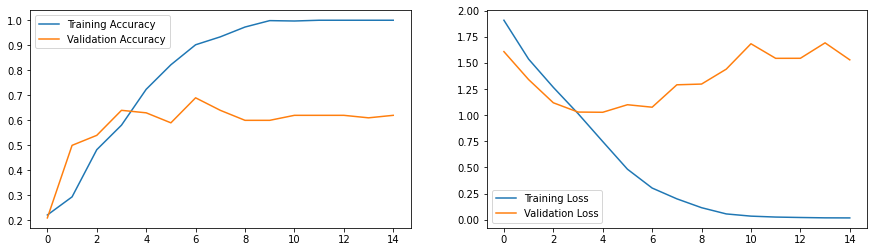

In [9]:
# Model Network
model_1 = Sequential([
            # First Conv Unit
            Conv3D(16,3,padding='same',activation="relu", input_shape = input_shape),
            MaxPooling3D(pool_size=2),

            # Second Conv Unit
            Conv3D(32,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),

            # Flatten
            Flatten(),

            # Dense networks to classify the input
            Dense(64,activation="relu"),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_1, name='model_1')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 15 | 
| Training Accuracy   | 1    | Training Loss     | 0.017 |
| Validation Accuracy | 0.62 | Validation Loss   | 1.53  |

> - The training loss seems to be **decreasing** whereas validation loss is **increasing** after every epoch.
> - This clearly shows the model is not good and it is **overfitting**.

---

### Experiment 2:

- There are many ways to remove overfitting. Before that, let's deepen the model and observe the behaviour.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 10, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 5, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 5, 60, 60, 32)     13856     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 2, 30, 30, 32)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 2, 30, 30, 64)     55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 1, 15, 15, 64)   

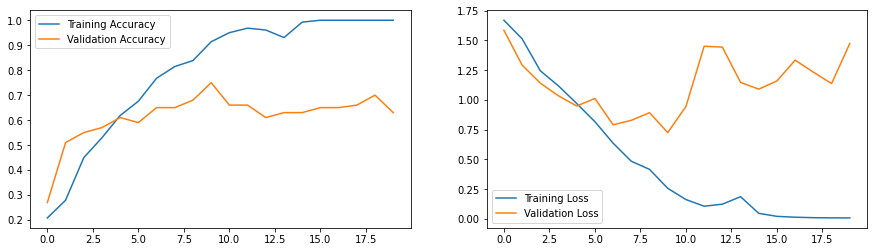

In [10]:
# Model Network
model_2 = Sequential([
            # First Conv Unit
            Conv3D(16,3,padding='same',activation="relu", input_shape = input_shape),
            MaxPooling3D(pool_size=2),

            # Second Conv Unit
            Conv3D(32,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),

            # Third Conv Unit
            Conv3D(64,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),

            # Flatten
            Flatten(),

            # Dense networks to classify the input
            Dense(128,activation="relu"),
            Dense(64,activation="relu"),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_2, name='model_2')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 19 | 
| Training Accuracy   | 1    | Training Loss     | 0.008 |
| Validation Accuracy | 0.70 | Validation Loss   | 1.1375  |

> - The training loss seems to be **decreasing** whereas validation loss is **increasing** after every epoch.
> - This clearly shows the model is still not good and it **overfitting**.

> - Though the model is overfitting, the metrics are better than model_1. Hence, let's improvise on this model_2.

---

### Experiment 3:

- Let's augment the training data to reduce overfitting on model_2.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 10, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 5, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 5, 60, 60, 32)     13856     
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 2, 30, 30, 32)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 2, 30, 30, 64)     55360     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 1, 15, 15, 64)   

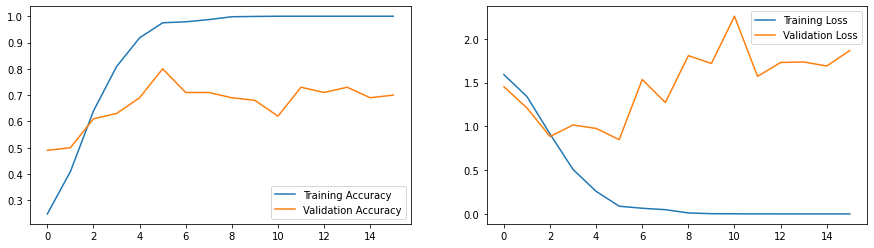

In [11]:
# Model Network
model_3 = Sequential([
            # First Conv Unit
            Conv3D(16,3,padding='same',activation="relu", input_shape = input_shape),
            MaxPooling3D(pool_size=2),

            # Second Conv Unit
            Conv3D(32,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),

            # Third Conv Unit
            Conv3D(64,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),

            # Flatten
            Flatten(),

            # Dense networks to classify the input
            Dense(128,activation="relu"),
            Dense(64,activation="relu"),
            Dense(num_classes,activation="softmax")
            ])

# Build and train the above model
build_and_train_model(model_3, name='model_3', is_augment=True)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 6 | 
| Training Accuracy   | 0.97511  | Training Loss     | 0.08835 |
| Validation Accuracy | 0.80     | Validation Loss   | 0.84911 |

> - The training loss seems to be **decreasing** and is almost *0* whereas validation loss is **increasing** after every epoch.
> - Though the metrics are high, the validation loss is *increasing* after every epoch and it is **overfitting**.

---

### Experiment 4:

- Let's add dropout layers to model_2 and see how it handles overfitting.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 10, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 5, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 60, 60, 16)     0         
                                                                 
 conv3d_9 (Conv3D)           (None, 5, 60, 60, 32)     13856     
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 2, 30, 30, 32)    0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 2, 30, 30, 32)    

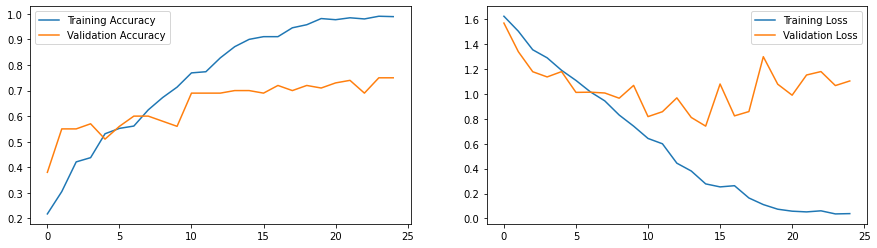

In [12]:
# Model Network
model_4 = Sequential([
            # First Conv Unit
            Conv3D(16,3,padding='same',activation="relu", input_shape = input_shape),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Second Conv Unit
            Conv3D(32,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Third Conv Unit
            Conv3D(64,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Flatten
            Flatten(),

            # Dense networks to classify the input
            Dense(128,activation="relu"),
            Dropout(0.2),
            Dense(64,activation="relu"),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_4, name='model_4')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 25 | 
| Training Accuracy   | 0.98944  | Training Loss     | 0.03880 |
| Validation Accuracy | 0.75     | Validation Loss   | 1.10293 |

> - The training loss seems to be **decreasing** whereas validation loss is **increasing** after every epoch.
> - Though the metrics are high, the validation loss is *increasing* after every epoch and it is **overfitting**.

> - Though the model is overfitting, the gap between training and validation metrics got reduced which shows dropout layers has reduced the overfitting.

---

### Experiment 5:

- Let's fuse model_3 and model_4, i.e., add dropout layers as well as augment the training data.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 10, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 5, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 5, 60, 60, 16)     0         
                                                                 
 conv3d_12 (Conv3D)          (None, 5, 60, 60, 32)     13856     
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 2, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 2, 30, 30, 32)    

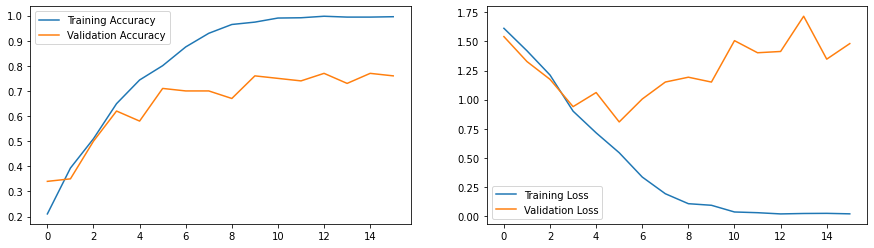

In [13]:
# Model Network
model_5 = Sequential([
            # First Conv Unit
            Conv3D(16,3,padding='same',activation="relu", input_shape = input_shape),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Second Conv Unit
            Conv3D(32,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Third Conv Unit
            Conv3D(64,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Flatten
            Flatten(),

            # Dense networks to classify the input
            Dense(128,activation="relu"),
            Dropout(0.2),
            Dense(64,activation="relu"),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_5, name='model_5', is_augment=True)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 13 | 
| Training Accuracy   | 0.99736  | Training Loss     | 0.01784 |
| Validation Accuracy | 0.77     | Validation Loss   | 1.41398 |

> - The training loss seems to be **decreasing** whereas validation loss is **increasing** after every epoch.
> - Though the model is overfitting, the gap between training and validation metrics got **reduced**.

> - This model is showing metrics similar to model_4.

---

### Experiment 6:

- We observed that, with dropout layers or with both data augmentation and dropout layers, the metrics and behaviour of the model is very similar.
- Let's improvise on model with dropout layers ,i.e. model_4, since it takes less training time and we get similar results.
    - Dropout layers, **model_4** = ~625s (25 epochs * 25 s/epoch)
    - Dropout layers + Data augmentation , **model_5** = ~960s (16 epochs * 60 s/epoch) )
- Let's add batch normalization layers to see if it improves the overall performance.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 10, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 5, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 5, 60, 60, 16)    64        
 ormalization)                                                   
                                                                 
 dropout_8 (Dropout)         (None, 5, 60, 60, 16)     0         
                                                                 
 conv3d_15 (Conv3D)          (None, 5, 60, 60, 32)     13856     
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 2, 30, 30, 32)   

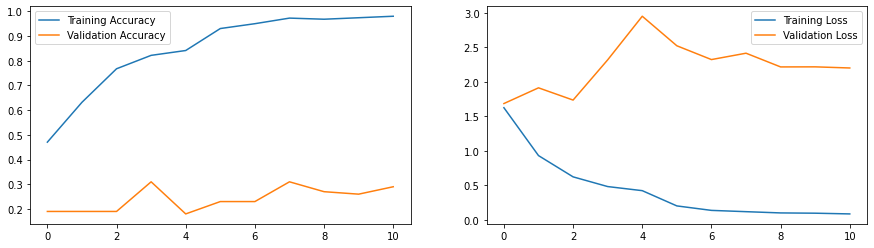

In [14]:
# Model Network
model_6 = Sequential([
            # First Conv Unit
            Conv3D(16,3,padding='same',activation="relu", input_shape = input_shape),
            MaxPooling3D(pool_size=2),
            BatchNormalization(),
            Dropout(0.2),

            # Second Conv Unit
            Conv3D(32,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            BatchNormalization(),
            Dropout(0.2),

            # Third Conv Unit
            Conv3D(64,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            BatchNormalization(),
            Dropout(0.2),

            # Flatten
            Flatten(),

            # Dense networks to classify the input
            Dense(128,activation="relu"),
            Dropout(0.2),
            Dense(64,activation="relu"),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_6, name='model_6')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 8 | 
| Training Accuracy   | 0.97285  | Training Loss     | 0.11892 |
| Validation Accuracy | 0.31     | Validation Loss   | 2.41390 |

> - This model is **overfitting** a lot.

---

### Experiment 7:

- Let's remove some dropout layer and batch normalization layer from model_6 and experiment.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_17 (Conv3D)          (None, 10, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 5, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_3 (Batc  (None, 5, 60, 60, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_18 (Conv3D)          (None, 5, 60, 60, 32)     13856     
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 2, 30, 30, 32)    0         
 g3D)                                                            
                                                      

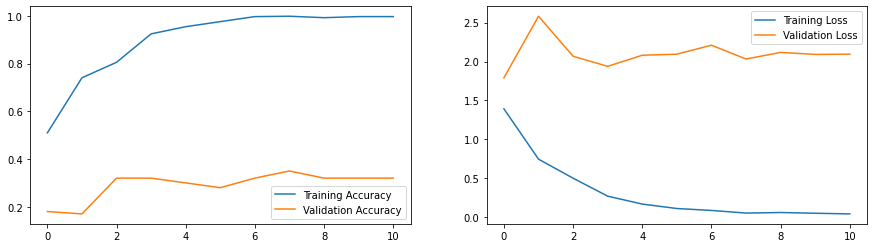

In [15]:
# Model Network
model_7 = Sequential([
            # First Conv Unit
            Conv3D(16,3,padding='same',activation="relu", input_shape = input_shape),
            MaxPooling3D(pool_size=2),
            BatchNormalization(),

            # Second Conv Unit
            Conv3D(32,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            BatchNormalization(),

            # Third Conv Unit
            Conv3D(64,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            BatchNormalization(),
            Dropout(0.2),

            # Flatten
            Flatten(),

            # Dense networks to classify the input
            Dense(128,activation="relu"),
            BatchNormalization(),
            Dense(64,activation="relu"),
            Dropout(0.2),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_7, name='model_7')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 11 | 
| Training Accuracy   | 0.997  | Training Loss     | 0.0406 |
| Validation Accuracy | 0.32     | Validation Loss   | 2.0948 |

> - This model is **overfitting** a lot.

---
<a id='conv3d_model_8'></a>
### Experiment 8:

- Let's replace Flatten layer with GlobalAveragePooling3D layer to see the performance improvement in model_4.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_23 (Conv3D)          (None, 10, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_23 (MaxPoolin  (None, 5, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 5, 60, 60, 16)     0         
                                                                 
 conv3d_24 (Conv3D)          (None, 5, 60, 60, 32)     13856     
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 2, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 2, 30, 30, 32)    

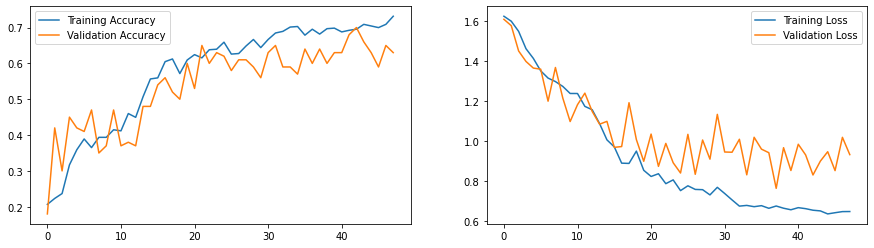

In [18]:
# Model Network
model_8 = Sequential([
            # First Conv Unit
            Conv3D(16,3,padding='same',activation="relu", input_shape = input_shape),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Second Conv Unit
            Conv3D(32,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Third Conv Unit
            Conv3D(64,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Global average pooling
            GlobalAveragePooling3D(),

            # Dense networks to classify the input
            Dense(128,activation="relu"),
            Dropout(0.2),
            Dense(64,activation="relu"),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_8, name='model_8')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 48 | 
| Training Accuracy   | 0.7315  | Training Loss     | 0.6465 |
| Validation Accuracy | 0.63    | Validation Loss   | 0.9315 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch.
> - Both training and validation metrics are **overlapping**.
> - The model metrics are low, but the model shows significant reduction in overfitting. This shows that global average pooling layer has significantly reduced the overfitting.

> - *model_8* could be considered as **good** model. Hence, Let's *improvise* on model_8.

---

### Experiment 9:

- Let's add batch normalization layers to model_8 to see the performance improvement.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 10, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 5, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_7 (Batc  (None, 5, 60, 60, 16)    64        
 hNormalization)                                                 
                                                                 
 dropout_26 (Dropout)        (None, 5, 60, 60, 16)     0         
                                                                 
 conv3d_31 (Conv3D)          (None, 5, 60, 60, 32)     13856     
                                                                 
 max_pooling3d_31 (MaxPoolin  (None, 2, 30, 30, 32)   

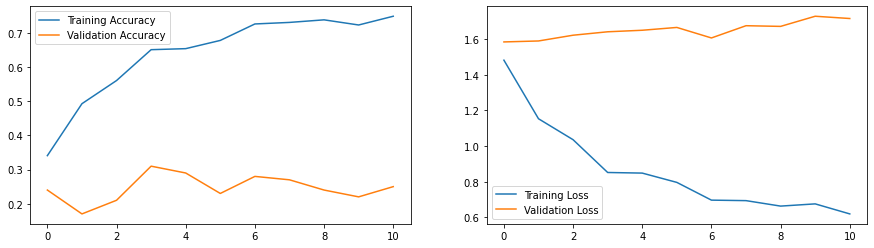

In [20]:
# Model Network
model_9 = Sequential([
            # First Conv Unit
            Conv3D(16,3,padding='same',activation="relu", input_shape = input_shape),
            MaxPooling3D(pool_size=2),
            BatchNormalization(),
            Dropout(0.2),

            # Second Conv Unit
            Conv3D(32,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            BatchNormalization(),
            Dropout(0.2),

            # Third Conv Unit
            Conv3D(64,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            BatchNormalization(),
            Dropout(0.2),

            # Global average pooling
            GlobalAveragePooling3D(),

            # Dense networks to classify the input
            Dense(128,activation="relu"),
            BatchNormalization(),
            Dropout(0.2),

            Dense(64,activation="relu"),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_9, name='model_9')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 11 | 
| Training Accuracy   | 0.7496  | Training Loss     | 0.6192 |
| Validation Accuracy | 0.25    | Validation Loss   | 1.7160 |

> - This model is **overfitting** a lot.

---

### Experiment 10:

- Let's add more conv layers to model_9 to see the performance improvement.
- To deepen the network, need to adjust the pooling layers to accomodate the depth.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 3, 58, 58, 64)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 58, 58, 128)    2

2024-01-28 08:54:44.699041: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-28 08:54:44.699104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Created Keras callbacks ....
# Training sequences =  663
# Validation sequences =  100
Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/50


2024-01-28 08:54:48.180419: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.4350 - categorical_accuracy: 0.4344Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_10_2024-01-2808_54_44.809462/model-00001-1.43501-0.43439-1.76733-0.23000.h5
21/21 [==============================] - 41s 2s/step - loss: 1.4350 - categorical_accuracy: 0.4344 - val_loss: 1.7673 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.0665 - categorical_accuracy: 0.5475
Epoch 00002: saving model to model_10_2024-01-2808_54_44.809462/model-00002-1.06649-0.54751-1.61279-0.32000.h5
21/21 [==============================] - 28s 1s/step - loss: 1.0665 - categorical_accuracy: 0.5475 - val_loss: 1.6128 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.9600 - categorical_accuracy: 0.5822
Epoch 00003: saving model to model_10_2024-01-2808_54_44.809462/model-0000

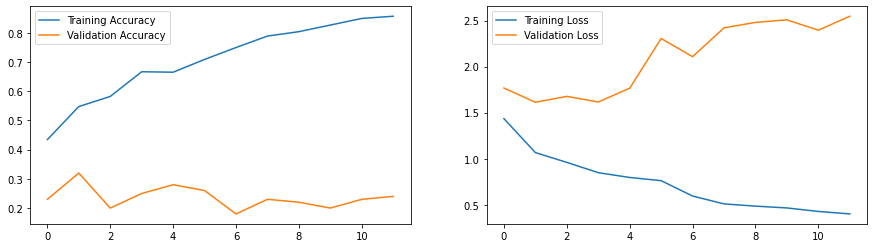

In [9]:
# Model Network
model_10 = Sequential([
            # First Conv Unit
            Conv3D(32,3,activation='relu', input_shape=input_shape),
            Conv3D(64,3,activation='relu'),
            MaxPooling3D(pool_size=2),
            BatchNormalization(),
            Dropout(0.2),

            # Second Conv Unit
            Conv3D(128,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=(1, 2, 2)),
            BatchNormalization(),
            Dropout(0.2),

            # Third Conv Unit
            Conv3D(256, kernel_size=(1, 3, 3), activation='relu'),
            MaxPooling3D(pool_size=(1, 2, 2)),
            BatchNormalization(),
            Dropout(0.2),

            # Global average pooling
            GlobalAveragePooling3D(),

            # Dense networks to classify the input
            Dense(512,activation="relu"),
            BatchNormalization(),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_10, name='model_10')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 12 | 
| Training Accuracy   | 0.8567  | Training Loss     | 0.4005 |
| Validation Accuracy | 0.24    | Validation Loss   | 2.5466 |

> - This model is **overfitting** a lot.

---

### Experiment 11:

- Let's add augmented training data to model_8 and see how it improves the performance.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 10, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 5, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 5, 60, 60, 16)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 5, 60, 60, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 2, 30, 30, 32)    0         
 3D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 2, 30, 30, 32)    

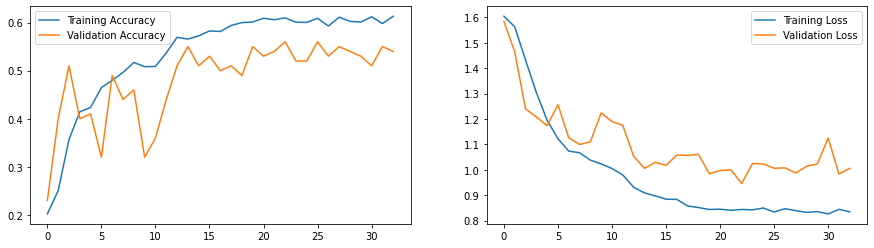

In [10]:
# Model Network
model_11 = Sequential([
            # First Conv Unit
            Conv3D(16,3,padding='same',activation="relu", input_shape = input_shape),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Second Conv Unit
            Conv3D(32,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Third Conv Unit
            Conv3D(64,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Global average pooling
            GlobalAveragePooling3D(),

            # Dense networks to classify the input
            Dense(128,activation="relu"),
            Dropout(0.2),
            Dense(64,activation="relu"),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_11, name='model_11', is_augment=True)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 26 | 
| Training Accuracy   | 0.60897  | Training Loss     | 0.83352 |
| Validation Accuracy | 0.56     | Validation Loss   | 1.00607 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch.
> - This model metrics are good, but the data augmentation did not improve the performance since we got **better** results without data augmentation in model_8.

---
<a id='conv3d_overall_inference'></a>
### Overall inference:

> - In Conv3D architecure based networks, we can consider **model_8** to be performing good with *87,429* total parameters and weights file size of *1090 KB*.

---
---

<a id='conv2d'></a>
## Convolutional2D + RNN
### Experiment 12:

- Let's start with simple RNN model with LSTM cell.

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 10, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 10, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 10, 60, 60, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 10, 30, 30, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 10, 64)          

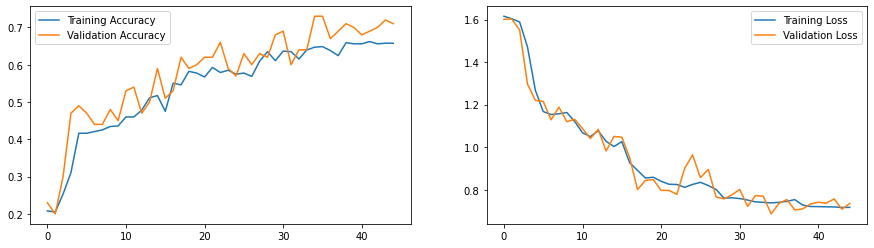

In [19]:
# Model Network
model_12 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(32,3,padding='same',activation="relu"), input_shape = input_shape),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Second Conv Unit
            TimeDistributed(Conv2D(64,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Global average pooling
            TimeDistributed(GlobalAveragePooling2D()),

            # RNN layer
            LSTM(128),

            # Dense networks to classify the input
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_12, name='model_12')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 44 | 
| Training Accuracy   | 0.65762  | Training Loss     | 0.71656 |
| Validation Accuracy | 0.72     | Validation Loss   | 0.70857 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch and closely overlapping.
> - The model is slightly **underfitting**.

---

### Experiment 13:

- Let's add more conv units to model_12 to see if we can reduce underfitting.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeDi  (None, 10, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 10, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 10, 60, 60, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 10, 30, 30, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 10, 30, 30, 128) 

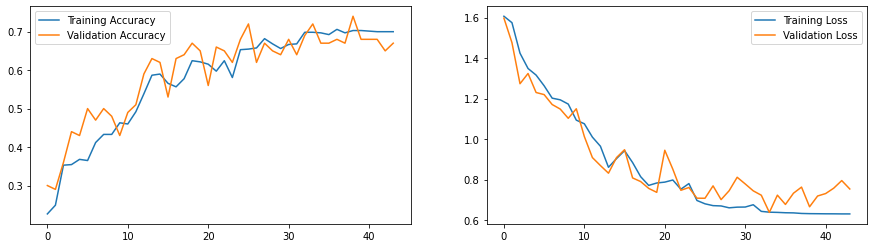

In [20]:
# Model Network
model_13 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(32,3,padding='same',activation="relu"), input_shape = input_shape),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Second Conv Unit
            TimeDistributed(Conv2D(64,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Third Conv Unit
            TimeDistributed(Conv2D(128,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Global average pooling
            TimeDistributed(GlobalAveragePooling2D()),

            # RNN layer
            LSTM(128),

            # Dense networks to classify the input
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_13, name='model_13')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 44 | 
| Training Accuracy   | 0.69985  | Training Loss     | 0.62993 |
| Validation Accuracy | 0.67     | Validation Loss   | 0.75315 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch and closely overlapping.
> - The model metrics are low, but the model shows **reduction** in underfitting. This shows that additional layer have worked.

> - *model_13* could be considered as **good** model. Hence, Let's *improvise* on model_13.

---

### Experiment 14:

- Let's add batch normalization layers in model_12 to see if there is any performance improvement.

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeDi  (None, 10, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 10, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_4 (Batc  (None, 10, 60, 60, 32)   128       
 hNormalization)                                                 
                                                                 
 time_distributed_44 (TimeDi  (None, 10, 60, 60, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 10, 30, 30, 64) 

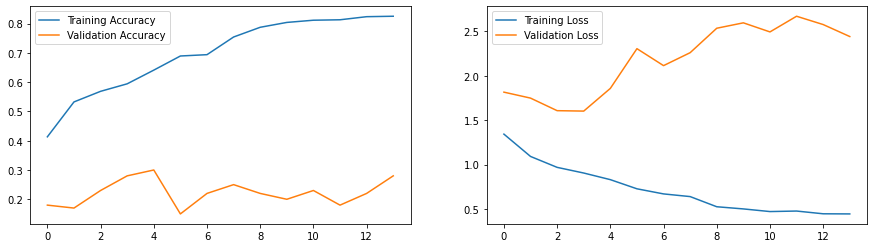

In [21]:
# Model Network
model_14 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(32,3,padding='same',activation="relu"), input_shape = input_shape),
            TimeDistributed(MaxPooling2D(pool_size=2)),
            BatchNormalization(),

            # Second Conv Unit
            TimeDistributed(Conv2D(64,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),
            BatchNormalization(),

            # Global average pooling
            TimeDistributed(GlobalAveragePooling2D()),

            # RNN layer
            LSTM(128),

            # Dense networks to classify the input
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_14, name='model_14')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 14 | 
| Training Accuracy   | 0.825  | Training Loss     | 0.4449 |
| Validation Accuracy | 0.28   | Validation Loss   | 2.4414 |

> - The model is **overfitting** a lot.

---
<a id='conv2d_model_15'></a>
### Experiment 15:

- Let's add augmented training data on model_13 to see if there is any performance improvement.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeDi  (None, 10, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 10, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 10, 60, 60, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 10, 30, 30, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 10, 30, 30, 128) 

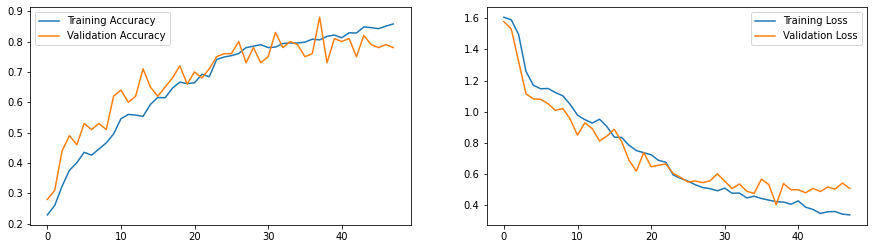

In [23]:
# Model Network
model_15 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(32,3,padding='same',activation="relu"), input_shape = input_shape),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Second Conv Unit
            TimeDistributed(Conv2D(64,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Third Conv Unit
            TimeDistributed(Conv2D(128,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Global average pooling
            TimeDistributed(GlobalAveragePooling2D()),

            # RNN layer
            LSTM(128),

            # Dense networks to classify the input
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_15, name='model_15', is_augment=True)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 44 | 
| Training Accuracy   | 0.84804  | Training Loss     | 0.34843 |
| Validation Accuracy | 0.82     | Validation Loss   | 0.48902 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch and closely overlapping.
> - The model is showing **good** accuracy metrics with fewer parameters.

> - model_15 could be considered as **good** model.

---

### Experiment 16:

- Let's replace LSTM cell with GRU cell in model_13 to see if the model performs good with even fewer parameters.

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_54 (TimeDi  (None, 10, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_55 (TimeDi  (None, 10, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 10, 60, 60, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_57 (TimeDi  (None, 10, 30, 30, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, 10, 30, 30, 128)

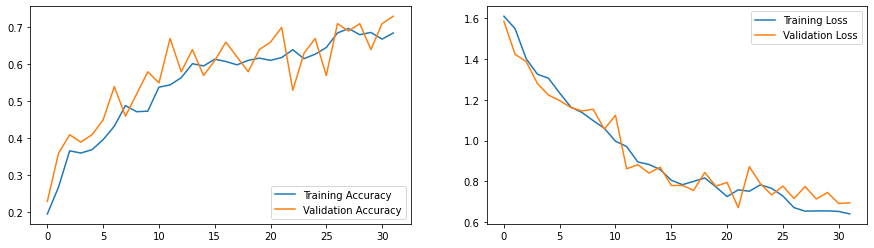

In [23]:
# Model Network
model_16 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(32,3,padding='same',activation="relu"), input_shape = input_shape),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Second Conv Unit
            TimeDistributed(Conv2D(64,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Third Conv Unit
            TimeDistributed(Conv2D(128,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Global average pooling
            TimeDistributed(GlobalAveragePooling2D()),

            # RNN layer
            GRU(128),

            # Dense networks to classify the input
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_16, name='model_16')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 32 | 
| Training Accuracy   | 0.6848  | Training Loss     | 0.6399 |
| Validation Accuracy | 0.73     | Validation Loss   | 0.6942 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch and closely overlapping.
> - The model is slightly **underfitting**.

---

### Experiment 17:

- Let's reduce model complexity of model_16 and see if it improves the performance.

2024-01-28 12:57:32.491120: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-28 12:57:32.491182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 120, 120, 8)  224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 60, 60, 8)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 60, 60, 16)   1168      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 30, 30, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 16)           0

2024-01-28 12:57:36.535249: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.6121 - categorical_accuracy: 0.1855Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_17_2024-01-2812_57_32.732089/model-00001-1.61211-0.18552-1.60338-0.23000.h5
21/21 [==============================] - 34s 1s/step - loss: 1.6121 - categorical_accuracy: 0.1855 - val_loss: 1.6034 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.6041 - categorical_accuracy: 0.2097
Epoch 00002: saving model to model_17_2024-01-2812_57_32.732089/model-00002-1.60411-0.20965-1.59525-0.21000.h5
21/21 [==============================] - 26s 1s/step - loss: 1.6041 - categorical_accuracy: 0.2097 - val_loss: 1.5953 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.5972 - categorical_accuracy: 0.2006
Epoch 00003: saving model to model_17_2024-01-2812_57_32.732089/model-0000

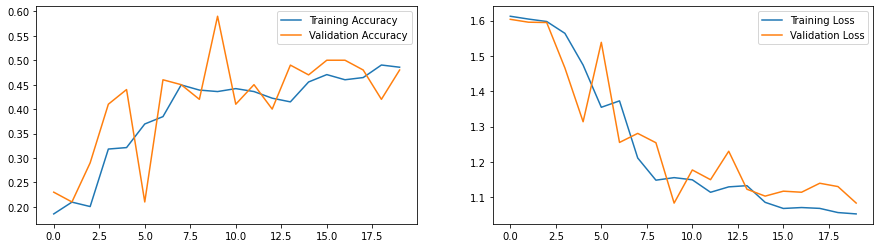

In [9]:
# Model Network
model_17 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(8,3,padding='same',activation="relu"), input_shape = input_shape),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Second Conv Unit
            TimeDistributed(Conv2D(16,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Global average pooling
            TimeDistributed(GlobalAveragePooling2D()),

            # RNN layer
            GRU(128),

            # Dense networks to classify the input
            Dense(64, activation='relu'),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_17, name='model_17')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 20 | 
| Training Accuracy   | 0.4857  | Training Loss     | 1.0527 |
| Validation Accuracy | 0.48     | Validation Loss   | 1.0835 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch.
> - The model is good but the metrics are **poor**.

---

### Experiment 18:

- Let's add another GRU layer in model_17 and see if it improves the performance.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 10, 120, 120, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 10, 60, 60, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 10, 60, 60, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 10, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 10, 16)          

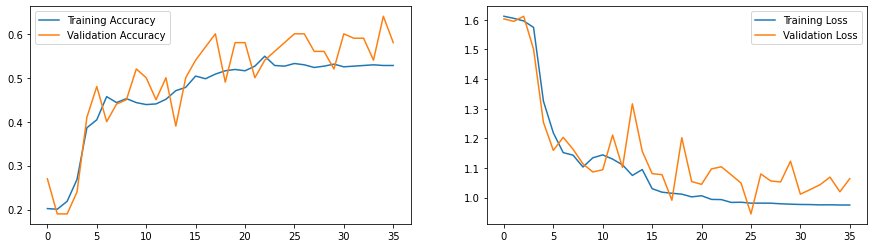

In [12]:
# Model Network
model_18 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(8,3,padding='same',activation="relu"), input_shape = input_shape),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Second Conv Unit
            TimeDistributed(Conv2D(16,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Global average pooling
            TimeDistributed(GlobalAveragePooling2D()),

            # RNN layer
            GRU(128, return_sequences=True),
            GRU(64),

            # Dense networks to classify the input
            Dense(64, activation='relu'),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_18, name='model_18')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 36 | 
| Training Accuracy   | 0.5279  | Training Loss     | 0.9748 |
| Validation Accuracy | 0.58     | Validation Loss   | 1.0639 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch and closely overlapping.
> - The model is slightly **underfitting**.

> - The model **did not** perform well despite adding another GRU layer.

---

### Experiment 19:

- Let's add ConvLSTM2D layer and see the performance.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 10, 120, 120, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 10, 60, 60, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 10, 60, 60, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 10, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 28, 28, 8)        

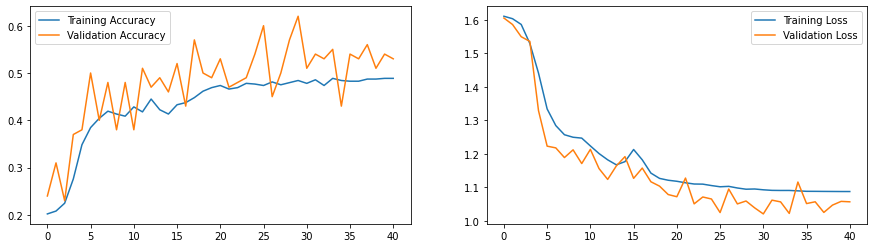

In [13]:
# Model Network
model_19 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(8,3,padding='same',activation="relu"), input_shape = input_shape),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Second Conv Unit
            TimeDistributed(Conv2D(16,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # RNN layer
            ConvLSTM2D(8, kernel_size = 3, return_sequences=False),

            # Global average pooling
            GlobalAveragePooling2D(),

            # Dense networks to classify the input
            Dense(64, activation='relu'),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_19, name='model_19')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 41 | 
| Training Accuracy   | 0.4887  | Training Loss     | 1.0873 |
| Validation Accuracy | 0.53     | Validation Loss   | 1.0566 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch and closely overlapping.
> - The model is slightly **underfitting**.

---

### Experiment 20:

- Let's deepen model_19 with dense layers to see if we can overcome underfitting.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_19 (TimeDi  (None, 10, 120, 120, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 10, 60, 60, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 10, 60, 60, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 10, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 28, 28, 8)        

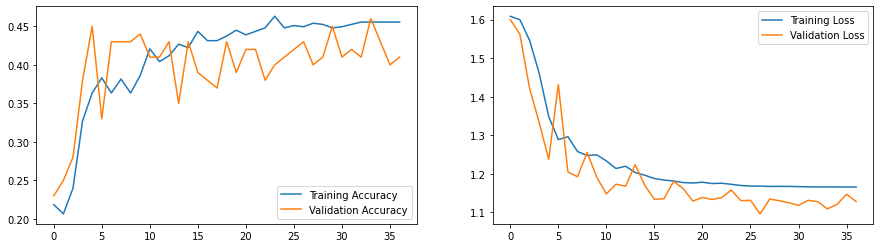

In [14]:
# Model Network
model_20 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(8,3,padding='same',activation="relu"), input_shape = input_shape),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Second Conv Unit
            TimeDistributed(Conv2D(16,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # RNN layer
            ConvLSTM2D(8, kernel_size = 3, return_sequences=False),

            # Dense network
            TimeDistributed(Dense(64, activation='relu')),

            # Global average pooling
            GlobalAveragePooling2D(),

            # Dense networks to classify the input
            Dense(64, activation='relu'),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_20, name='model_20')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 35 | 
| Training Accuracy   | 0.45551  | Training Loss     | 1.16585 |
| Validation Accuracy | 0.43     | Validation Loss   | 1.12072 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch and closely overlapping.
> - The model has *overcome* underfitting issue, but has **poor** metrics still.

---

### Experiment 21:

- Let's add batch normalization layers to model_20 and see if there is any performance improvement.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 10, 120, 120, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 10, 60, 60, 8)    0         
 stributed)                                                      
                                                                 
 batch_normalization (BatchN  (None, 10, 60, 60, 8)    32        
 ormalization)                                                   
                                                                 
 time_distributed_26 (TimeDi  (None, 10, 60, 60, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 10, 30, 30, 16)  

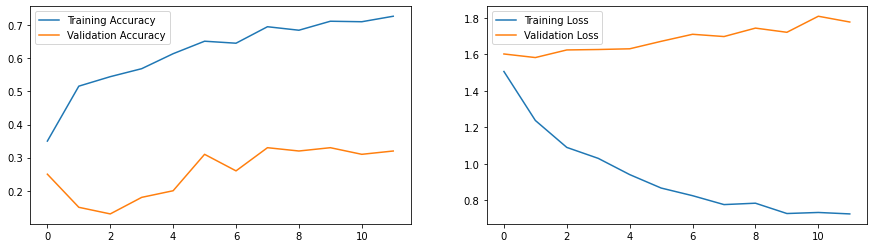

In [15]:
# Model Network
model_21 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(8,3,padding='same',activation="relu"), input_shape = input_shape),
            TimeDistributed(MaxPooling2D(pool_size=2)),
            BatchNormalization(),

            # Second Conv Unit
            TimeDistributed(Conv2D(16,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),
            BatchNormalization(),

            # RNN layer
            ConvLSTM2D(8, kernel_size = 3, return_sequences=False),
            BatchNormalization(),

            # Dense network
            TimeDistributed(Dense(64, activation='relu')),
            BatchNormalization(),

            # Global average pooling
            GlobalAveragePooling2D(),

            # Dense networks to classify the input
            Dense(64, activation='relu'),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_21, name='model_21')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 12 | 
| Training Accuracy   | 0.7270  | Training Loss     | 0.7256 |
| Validation Accuracy | 0.32     | Validation Loss   | 1.7764 |

> - The model is **overfitting** a lot.

---

### Experiment 22:

- Let's remove the max pool layers in model_21 and see if it improves the performance.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 10, 120, 120, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_4 (Batc  (None, 10, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 time_distributed_30 (TimeDi  (None, 10, 120, 120, 16)  1168     
 stributed)                                                      
                                                                 
 batch_normalization_5 (Batc  (None, 10, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 118, 118, 8)      

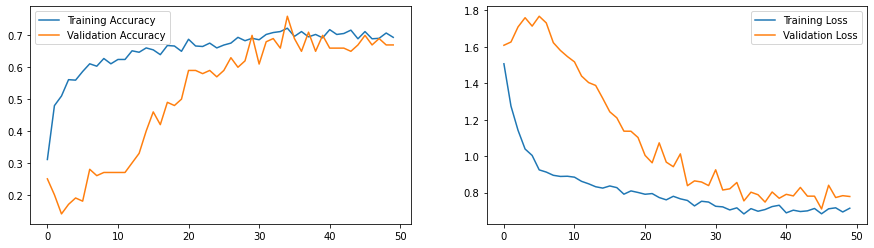

In [16]:
# Model Network
model_22 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(8,3,padding='same',activation="relu"), input_shape = input_shape),
            BatchNormalization(),

            # Second Conv Unit
            TimeDistributed(Conv2D(16,3,padding='same',activation="relu")),
            BatchNormalization(),

            # RNN layer
            ConvLSTM2D(8, kernel_size = 3, return_sequences=False),
            BatchNormalization(),

            # Dense network
            TimeDistributed(Dense(64, activation='relu')),
            BatchNormalization(),

            # Global average pooling
            GlobalAveragePooling2D(),

            # Dense networks to classify the input
            Dense(64, activation='relu'),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_22, name='model_22')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 46 | 
| Training Accuracy   | 0.71192  | Training Loss     | 0.68310 |
| Validation Accuracy | 0.70     | Validation Loss   | 0.70960 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch.
> - The model is showing **good** accuracy metrics with fewer parameters.

---
<a id='conv2d_model_23'></a>
### Experiment 23:

- Let's add augmented training data to model_22 and see if it improves performance.

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_34 (TimeDi  (None, 10, 120, 120, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 10, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_35 (TimeDi  (None, 10, 120, 120, 16)  1168     
 stributed)                                                      
                                                                 
 batch_normalization_14 (Bat  (None, 10, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 118, 118, 8)     

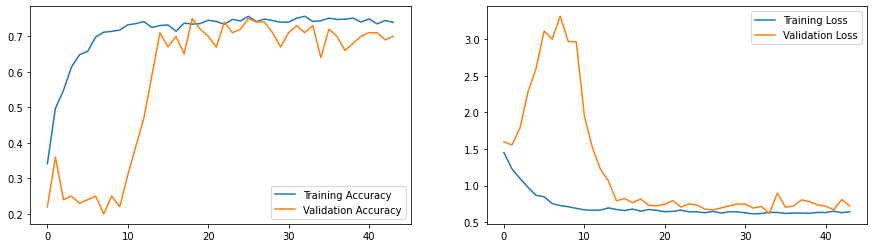

In [24]:
# Model Network
model_23 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(8,3,padding='same',activation="relu"), input_shape = input_shape),
            BatchNormalization(),

            # Second Conv Unit
            TimeDistributed(Conv2D(16,3,padding='same',activation="relu")),
            BatchNormalization(),

            # RNN layer
            ConvLSTM2D(8, kernel_size = 3, return_sequences=False),
            BatchNormalization(),

            # Dense network
            TimeDistributed(Dense(64, activation='relu')),
            BatchNormalization(),

            # Global average pooling
            GlobalAveragePooling2D(),

            # Dense networks to classify the input
            Dense(64, activation='relu'),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_23, name='model_23', is_augment=True)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 26 | 
| Training Accuracy   | 0.75603  | Training Loss     | 0.62860 |
| Validation Accuracy | 0.75    | Validation Loss   | 0.67698 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch and closely overlapping.
> - The model is showing **good** accuracy metrics with very few parameters.

> - model_23 could be considered as **good** model.

---

### Experiment 24:

- Let's tweak the network and see if it improves the performance.
- Let's make the padding as 'valid'.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 10, 118, 118, 8)  224       
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 10, 118, 118, 8)  32        
 hNormalization)                                                 
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 10, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 114, 114, 8)      

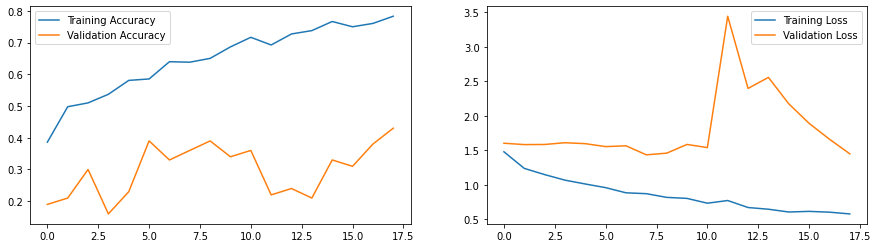

In [13]:
# Model Network
model_24 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(8,3,padding='valid',activation="relu"), input_shape = input_shape),
            BatchNormalization(),

            # Second Conv Unit
            TimeDistributed(Conv2D(16,3,padding='valid',activation="relu")),
            BatchNormalization(),

            # RNN layer
            ConvLSTM2D(8, kernel_size = 3, return_sequences=False),
            BatchNormalization(),

            # Dense network
            TimeDistributed(Dense(64, activation='relu')),
            BatchNormalization(),

            # Global average pooling
            GlobalAveragePooling2D(),

            # Dense networks to classify the input
            Dense(64, activation='relu'),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_24, name='model_24')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 18 | 
| Training Accuracy   | 0.7828  | Training Loss     | 0.5790 |
| Validation Accuracy | 0.43    | Validation Loss   | 1.4493 |

> - The model is **overfitting** a lot.

---
<a id='conv2d_overall_inference'></a>
### Overall inference:

- In Conv2D with RNN architecure based networks, we can consider below models to be performing good
> - **model_15** with *225,477* total parameters and weights file size of *2700 KB*.
> - **model_23** with *13,781* total parameters and weights file size of *254 KB*.

---
---
<a id='transfer_learning'></a>
## Transfer Learning + RNN

- Till now we built our custom model, let's experiment on pre-trained models.

### Experiment 25:

- Let's experiment on mobile net V2 for feature extraction and LSTM cell.

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 10, 3, 3, 1280)   2257984   
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 11520)        0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)               12059648  
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 5)                 1285      
                                                         

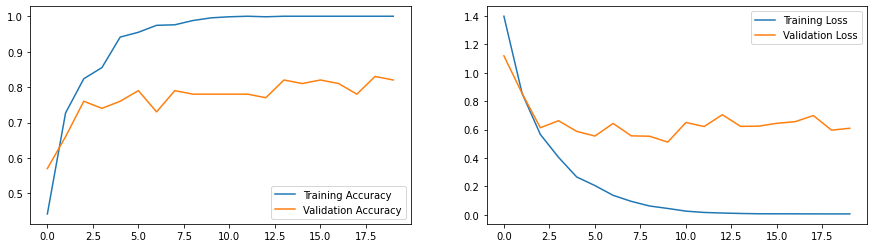

In [15]:
# Fetch pre-trained weights from mobile net v2
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)

model_25 = Sequential([
    TimeDistributed(mobilenet, input_shape=input_shape)
])

# Freeze the weights of mobile net
for layer in model_25.layers:
    layer.trainable = False

# Add custom layers for required task
# Flatten the output from pre-trained model
model_25.add(TimeDistributed(Flatten()))

# RNN layer
model_25.add(LSTM(256))

# Dense networks to classify the input
model_25.add(Dense(256,activation='relu'))
model_25.add(Dense(num_classes, activation='softmax'))

# Build and train the above model
build_and_train_model(model_25, name='model_25')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 19 | 
| Training Accuracy   | 1.0  | Training Loss     | 0.00660 |
| Validation Accuracy | 0.83 | Validation Loss   | 0.59641 |

> - Training loss is **decreasing** but validation loss seems to be **flattening** and slightly increasing after few epochs.
> - Though the training accuracy is **1**, the validation accuracy is **0.83**. This shows the model is overfitting.

---

### Experiment 26:

- Let's add dropout layers to model_25 and see if we can overcome overfitting.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 10, 3, 3, 1280)   2257984   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 10, 11520)        0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 256)               12059648  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)              

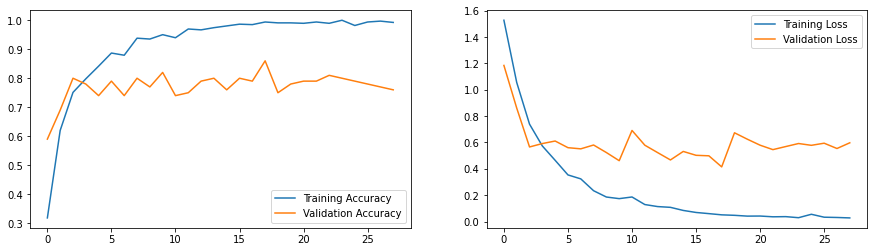

In [17]:
# Fetch pre-trained weights from mobile net v2
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)

model_26 = Sequential([
    TimeDistributed(mobilenet, input_shape=input_shape)
])

# Freeze the weights of mobile net
for layer in model_26.layers:
    layer.trainable = False

# Add custom layers for required task
# Flatten the output from pre-trained model
model_26.add(TimeDistributed(Flatten()))

# RNN layer
model_26.add(LSTM(256))
model_26.add(Dropout(0.2))

# Dense networks to classify the input
model_26.add(Dense(256,activation='relu'))
model_26.add(Dropout(0.2))
model_26.add(Dense(num_classes, activation='softmax'))

# Build and train the above model
build_and_train_model(model_26, name='model_26')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 23 | 
| Training Accuracy   | 0.98944  | Training Loss     | 0.03743 |
| Validation Accuracy | 0.81 | Validation Loss   | 0.56922 |

> - Training loss is **decreasing** but validation loss seems to be **flattening** and slightly increasing after few epochs.
> - Though the model is overfitting, the gap seems to have slightly **reduced** than the previous model.

---

### Experiment 27:

- Let's add batch normalization layer to model_26 and check the performance improvement.
- Let's add max pooling layer to model_26 and see if we can reduce overfitting.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 10, 3, 3, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 10, 3, 3, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 10, 1, 1, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 10, 1280)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 256)              

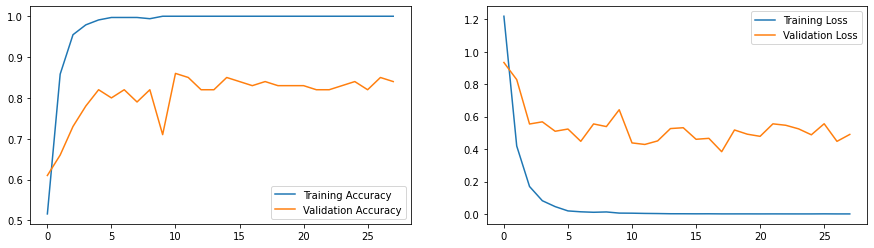

In [19]:
# Fetch pre-trained weights from mobile net v2
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)

model_27 = Sequential([
    TimeDistributed(mobilenet, input_shape=input_shape)
])

# Freeze the weights of mobile net
for layer in model_27.layers:
    layer.trainable = False

# Add custom layers for required task
model_27.add(TimeDistributed(BatchNormalization()))
model_27.add(TimeDistributed(MaxPooling2D(pool_size=2)))

# Flatten the output from pre-trained model
model_27.add(TimeDistributed(Flatten()))

# RNN layer
model_27.add(LSTM(256))
model_27.add(Dropout(0.2))

# Dense networks to classify the input
model_27.add(Dense(256,activation='relu'))
model_27.add(Dropout(0.2))
model_27.add(Dense(num_classes, activation='softmax'))

# Build and train the above model
build_and_train_model(model_27, name='model_27')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 27 | 
| Training Accuracy   | 1.0  | Training Loss     | 0.00053 |
| Validation Accuracy | 0.85 | Validation Loss   | 0.44770 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch.
> - Though the model is overfitting, the gap seems to have slightly **reduced** than the previous model.

---
<a id='transfer_learning_model_28'></a>
### Experiment 28:

- Let's replace LSTM cell with GRU cell in model_27 to see if we get similar performance with lesser parameters.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_19 (TimeDi  (None, 10, 3, 3, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 10, 3, 3, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 10, 1, 1, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 10, 1280)         0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 256)              

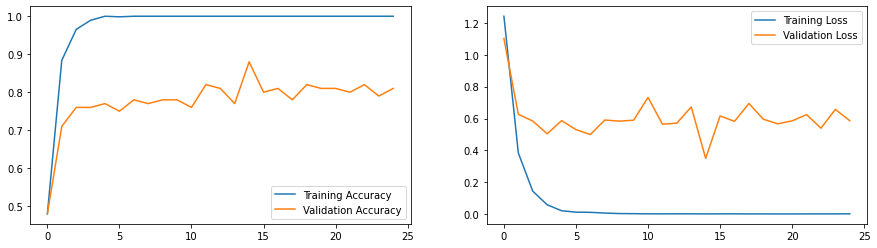

In [21]:
# Fetch pre-trained weights from mobile net v2
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)

model_28 = Sequential([
    TimeDistributed(mobilenet, input_shape=input_shape)
])

# Freeze the weights of mobile net
for layer in model_28.layers:
    layer.trainable = False

# Add custom layers for required task
model_28.add(TimeDistributed(BatchNormalization()))
model_28.add(TimeDistributed(MaxPooling2D(pool_size=2)))

# Flatten the output from pre-trained model
model_28.add(TimeDistributed(Flatten()))

# RNN layer
model_28.add(GRU(256))
model_28.add(Dropout(0.2))

# Dense networks to classify the input
model_28.add(Dense(256,activation='relu'))
model_28.add(Dropout(0.2))
model_28.add(Dense(num_classes, activation='softmax'))

# Build and train the above model
build_and_train_model(model_28, name='model_28')

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 15 | 
| Training Accuracy   | 1.0  | Training Loss     | 0.00159 |
| Validation Accuracy | 0.88 | Validation Loss   | 0.34987 |

> - Both the training loss and validation loss seems to be **decreasing** after every epoch.
> - The change in metrics is very small after few epochs, this might be due to the saturation in learning as model was loaded with pre-trained weights.
> - The model shows overall **good** metrics.

> - model_28 could be considered as **good** model.
---

### Experiment 29:

- The previous model is overall good, but let's still experiment on model_28 with augmented training data.

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_23 (TimeDi  (None, 10, 3, 3, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 10, 3, 3, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 10, 1, 1, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 10, 1280)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 256)              

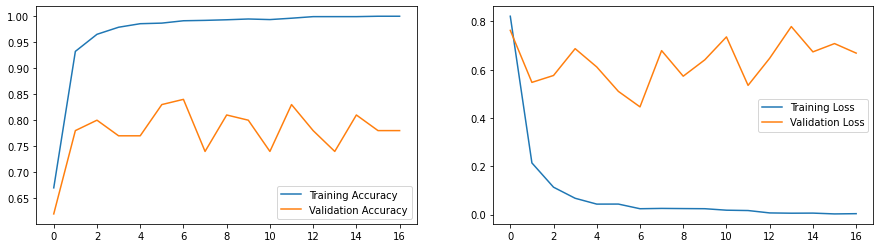

In [22]:
# Fetch pre-trained weights from mobile net v2
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)

model_29 = Sequential([
    TimeDistributed(mobilenet, input_shape=input_shape)
])

# Freeze the weights of mobile net
for layer in model_29.layers:
    layer.trainable = False

# Add custom layers for required task
model_29.add(TimeDistributed(BatchNormalization()))
model_29.add(TimeDistributed(MaxPooling2D(pool_size=2)))

# Flatten the output from pre-trained model
model_29.add(TimeDistributed(Flatten()))

# RNN layer
model_29.add(GRU(256))
model_29.add(Dropout(0.2))

# Dense networks to classify the input
model_29.add(Dense(256,activation='relu'))
model_29.add(Dropout(0.2))
model_29.add(Dense(num_classes, activation='softmax'))

# Build and train the above model
build_and_train_model(model_29, name='model_29', is_augment=True)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 9 | 
| Training Accuracy   | 0.99284  | Training Loss     | 0.02506 |
| Validation Accuracy | 0.81 | Validation Loss   | 0.57340 |

> - Training loss is **decreasing** and validation loss is **increasing** after every epoch.
> - The model seems to be **overfitting**.

---
<a id='transfer_learning_overall_inference'></a>
### Overall inference:

> - In Transfer learning + RNN based networks, we can consider **model_28** to be performing good with *3,511,365* total parameters and weights file size of *23.3 MB*.

---
---
<a id='additional'></a>
## Additional experiments on input parameters

- Till now, we were modifying architecture to get good results.
- Let's now take the best models we got till now, and play around input parameters and see if we can get still better results.
- An example change in looks like below.

Source path =  /home/datasets/Project_data/train ; batch size = 1


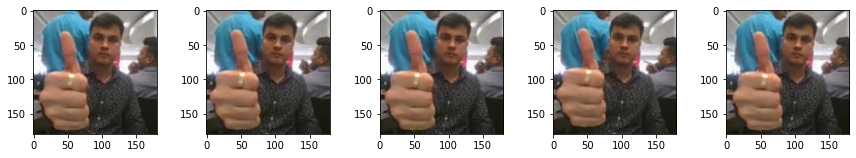

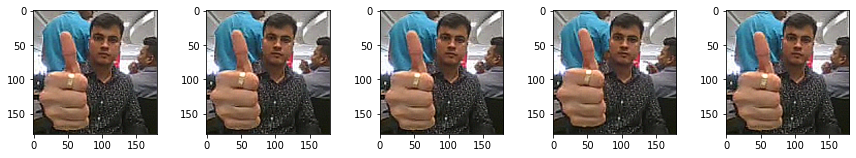

In [13]:
# Test the generator with batch size of 1
seq=range(5,25,4)
sample_gen_1 = generator(train_path, train_doc, 1, is_train = True, is_augment = True, debug = True, image_height=180 , image_width=180 , img_idx=seq)
data = next(sample_gen_1)[0]

# Plot the yielded batch
for idx in range(0,len(data)):
    plt.figure(figsize=(15, len(data[idx])))
    pos = 1
    for n in range(0,len(data[idx])):
        plt.subplot(len(data), len(data[idx]), pos)
        plt.imshow(data[idx][n])
        pos = pos+1
    plt.pause(2)

---

### Experiment 30:

- Experiment on model_8 by increasing the number of frames to 20 and image resolution to (180,180).

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 20, 180, 180, 16)  1312      
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 10, 90, 90, 16)   0         
 g3D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 10, 90, 90, 16)    0         
                                                                 
 conv3d_31 (Conv3D)          (None, 10, 90, 90, 32)    13856     
                                                                 
 max_pooling3d_31 (MaxPoolin  (None, 5, 45, 45, 32)    0         
 g3D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 5, 45, 45, 32)   

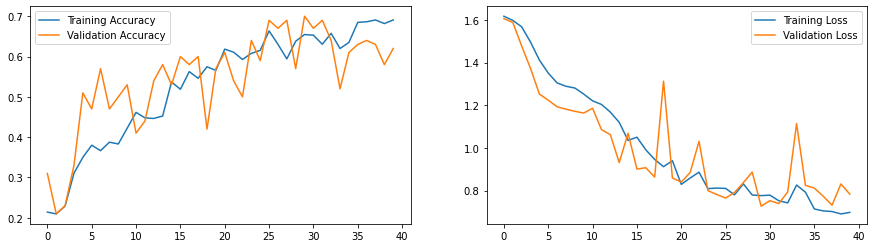

In [24]:
# sequence ids - selecting frames from 5 to 25.
seq_idx = range(5,25,1)

# image dimensions
dim_x, dim_y = 180, 180

# input shape for the first layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)

# Model Network
model_8_1 = Sequential([
            # First Conv Unit
            Conv3D(16,3,padding='same',activation="relu", input_shape = input_shape),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Second Conv Unit
            Conv3D(32,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Third Conv Unit
            Conv3D(64,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Global average pooling
            GlobalAveragePooling3D(),

            # Dense networks to classify the input
            Dense(128,activation="relu"),
            Dropout(0.2),
            Dense(64,activation="relu"),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_8_1, name='model_8_1', image_height=dim_y, image_width=dim_x, img_idx=seq_idx, batch_size=batch_size)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 38 | 
| Training Accuracy   | 0.6908  | Training Loss     | 0.70205 |
| Validation Accuracy | 0.63 | Validation Loss   | 0.73179 |

> - The metrics are good, but it is **not** better than model_8.

---

### Experiment 31:

- Experiment on model_8 by increasing the number of frames to 20.

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_33 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 10, 60, 60, 16)    0         
                                                                 
 conv3d_34 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_34 (MaxPoolin  (None, 5, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 5, 30, 30, 32)   

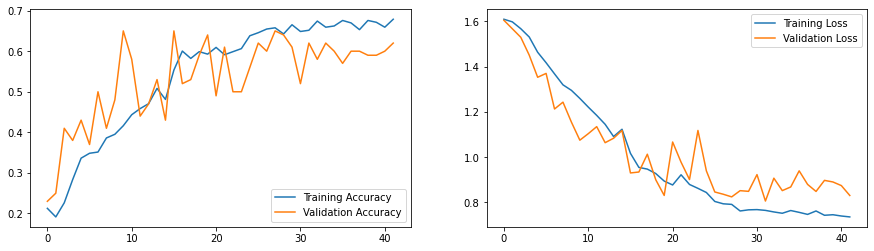

In [25]:
# sequence ids - selecting frames from 5 to 25.
seq_idx = range(5,25,1)

# image dimensions
dim_x, dim_y = 120, 120

# input shape for the first layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)

# Model Network
model_8_2 = Sequential([
            # First Conv Unit
            Conv3D(16,3,padding='same',activation="relu", input_shape = input_shape),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Second Conv Unit
            Conv3D(32,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Third Conv Unit
            Conv3D(64,3,padding='same',activation="relu"),
            MaxPooling3D(pool_size=2),
            Dropout(0.2),

            # Global average pooling
            GlobalAveragePooling3D(),

            # Dense networks to classify the input
            Dense(128,activation="relu"),
            Dropout(0.2),
            Dense(64,activation="relu"),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_8_2, name='model_8_2', image_height=dim_y, image_width=dim_x, img_idx=seq_idx, batch_size=batch_size)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 42 | 
| Training Accuracy   | 0.6787  | Training Loss     | 0.7343 |
| Validation Accuracy | 0.62 | Validation Loss   | 0.8293 |

> - The metrics are good, but it is **not** better than model_8.

---

### Experiment 32:

- Experiment on model_15 by increasing the number of frames to 20 and image resolution to (180,180).

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 20, 180, 180, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 20, 90, 90, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 20, 90, 90, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 20, 45, 45, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 20, 45, 45, 128)

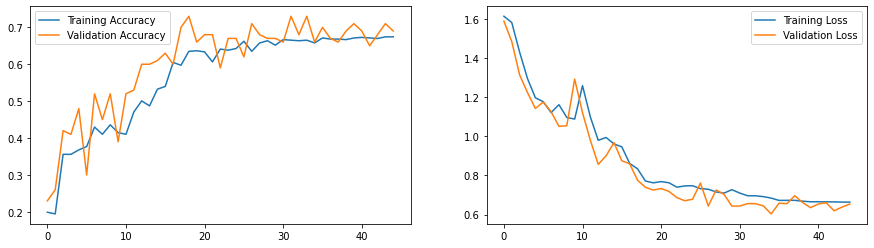

In [27]:
# sequence ids - selecting frames from 5 to 25.
seq_idx = range(5,25,1)

# image dimensions
dim_x, dim_y = 180, 180

# input shape for the first layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)

# Model Network
model_15_1 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(32,3,padding='same',activation="relu"), input_shape = input_shape),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Second Conv Unit
            TimeDistributed(Conv2D(64,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Third Conv Unit
            TimeDistributed(Conv2D(128,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Global average pooling
            TimeDistributed(GlobalAveragePooling2D()),

            # RNN layer
            LSTM(128),

            # Dense networks to classify the input
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_15_1, name='model_15_1', image_height=dim_y, image_width=dim_x, img_idx=seq_idx, batch_size=batch_size)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 42 | 
| Training Accuracy   | 0.67119  | Training Loss     | 0.66526 |
| Validation Accuracy | 0.65 | Validation Loss   | 0.66063 |

> - The metrics are good, but it is **not** better than model_15.

---

### Experiment 33:

- Experiment on model_15 by increasing the number of frames to 20.

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 20, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 60, 60, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 30, 30, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 30, 30, 128)

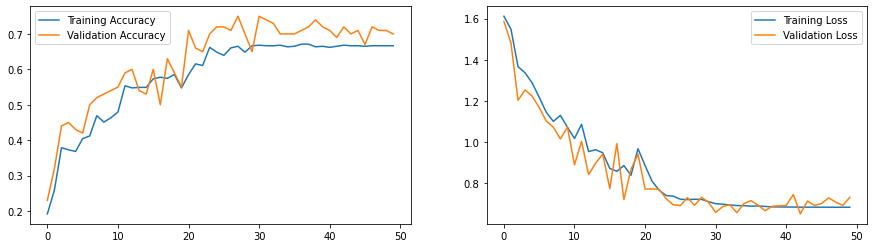

In [28]:
# sequence ids - selecting frames from 5 to 25.
seq_idx = range(5,25,1)

# image dimensions
dim_x, dim_y = 120, 120

# input shape for the first layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)

# Model Network
model_15_2 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(32,3,padding='same',activation="relu"), input_shape = input_shape),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Second Conv Unit
            TimeDistributed(Conv2D(64,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Third Conv Unit
            TimeDistributed(Conv2D(128,3,padding='same',activation="relu")),
            TimeDistributed(MaxPooling2D(pool_size=2)),

            # Global average pooling
            TimeDistributed(GlobalAveragePooling2D()),

            # RNN layer
            LSTM(128),

            # Dense networks to classify the input
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_15_2, name='model_15_2', image_height=dim_y, image_width=dim_x, img_idx=seq_idx, batch_size=batch_size)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 50 | 
| Training Accuracy   | 0.67  | Training Loss     | 0.6829 |
| Validation Accuracy | 0.70 | Validation Loss   | 0.731 |

> - The model is slightly underfitting and it is **not** better than model_15.

---

### Experiment 34:

- Experiment on model_23 by increasing the number of frames to 20 and image resolution to (180,180).

In [32]:
# sequence ids - selecting frames from 5 to 25.
seq_idx = range(5,25,1)

# image dimensions
dim_x, dim_y = 180, 180

# input shape for the first layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)

# Model Network
model_23_1 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(8,3,padding='same',activation="relu"), input_shape = input_shape),
            BatchNormalization(),

            # Second Conv Unit
            TimeDistributed(Conv2D(16,3,padding='same',activation="relu")),
            BatchNormalization(),

            # RNN layer
            ConvLSTM2D(8, kernel_size = 3, return_sequences=False),
            BatchNormalization(),

            # Dense network
            TimeDistributed(Dense(64, activation='relu')),
            BatchNormalization(),

            # Global average pooling
            GlobalAveragePooling2D(),

            # Dense networks to classify the input
            Dense(64, activation='relu'),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
# build_and_train_model(model_23_1, name='model_23_1', image_height=dim_y, image_width=dim_x, img_idx=seq_idx, batch_size=batch_size)

########################################################
## Facing resource OOM error due to limited availability.

# Inference:

> - Facing resource OOM error due to limited availability.

---

### Experiment 35:

- Experiment on model_23 by increasing the number of frames to 20.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 8)  224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 120, 120, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 118, 118, 8)       6

2024-01-29 08:57:08.136398: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-29 08:57:08.136473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Created Keras callbacks ....
# Training sequences =  663
# Validation sequences =  100
Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/50


2024-01-29 08:57:14.316301: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.5036 - categorical_accuracy: 0.3077Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_23_2_2024-01-2908_57_08.324750/model-00001-1.50357-0.30769-1.60957-0.17000.h5
21/21 [==============================] - 63s 3s/step - loss: 1.5036 - categorical_accuracy: 0.3077 - val_loss: 1.6096 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.2841 - categorical_accuracy: 0.4374
Epoch 00002: saving model to model_23_2_2024-01-2908_57_08.324750/model-00002-1.28406-0.43741-1.60456-0.14000.h5
21/21 [==============================] - 49s 2s/step - loss: 1.2841 - categorical_accuracy: 0.4374 - val_loss: 1.6046 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.1493 - categorical_accuracy: 0.5083
Epoch 00003: saving model to model_23_2_2024-01-2908_57_08.324750/mode

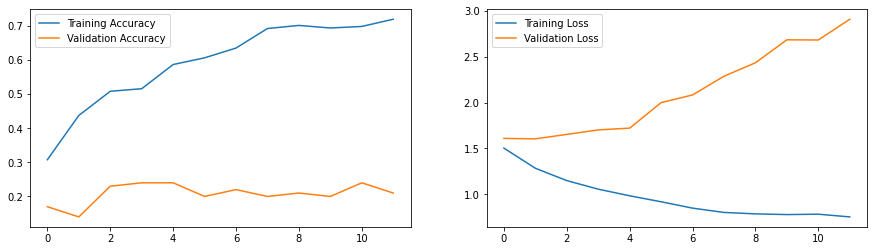

In [12]:
# sequence ids - selecting frames from 5 to 25.
seq_idx = range(5,25,1)

# image dimensions
dim_x, dim_y = 120, 120

# input shape for the first layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)

# Model Network
model_23_2 = Sequential([
            # First Conv Unit
            TimeDistributed(Conv2D(8,3,padding='same',activation="relu"), input_shape = input_shape),
            BatchNormalization(),

            # Second Conv Unit
            TimeDistributed(Conv2D(16,3,padding='same',activation="relu")),
            BatchNormalization(),

            # RNN layer
            ConvLSTM2D(8, kernel_size = 3, return_sequences=False),
            BatchNormalization(),

            # Dense network
            TimeDistributed(Dense(64, activation='relu')),
            BatchNormalization(),

            # Global average pooling
            GlobalAveragePooling2D(),

            # Dense networks to classify the input
            Dense(64, activation='relu'),
            Dense(num_classes,activation="softmax")
])

# Build and train the above model
build_and_train_model(model_23_2, name='model_23_2', image_height=dim_y, image_width=dim_x, img_idx=seq_idx, batch_size=batch_size)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 12 | 
| Training Accuracy   | 0.7195  | Training Loss     | 0.7535 |
| Validation Accuracy | 0.21 | Validation Loss   | 2.9088 |

> - The model is **overfitting** a lot.

---

### Experiment 36:

- Experiment on model_28 by increasing the number of frames to 20 and image dimensions to (180, 180).

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 5, 5, 1280)   2257984   
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 5, 5, 1280)   5120      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 2, 2, 1280)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 5120)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 256)              

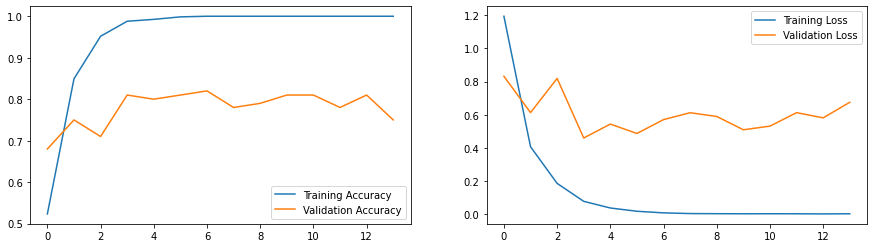

In [13]:
# sequence ids - selecting frames from 5 to 25.
seq_idx = range(5,25,1)

# image dimensions
dim_x, dim_y = 180, 180

# input shape for the first layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)

# Fetch pre-trained weights from mobile net v2
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)

model_28_1 = Sequential([
    TimeDistributed(mobilenet, input_shape=input_shape)
])

# Freeze the weights of mobile net
for layer in model_28_1.layers:
    layer.trainable = False

# Add custom layers for required task
model_28_1.add(TimeDistributed(BatchNormalization()))
model_28_1.add(TimeDistributed(MaxPooling2D(pool_size=2)))

# Flatten the output from pre-trained model
model_28_1.add(TimeDistributed(Flatten()))

# RNN layer
model_28_1.add(GRU(256))
model_28_1.add(Dropout(0.2))

# Dense networks to classify the input
model_28_1.add(Dense(256,activation='relu'))
model_28_1.add(Dropout(0.2))
model_28_1.add(Dense(num_classes, activation='softmax'))

# Build and train the above model
build_and_train_model(model_28_1, name='model_28_1', image_height=dim_y, image_width=dim_x, img_idx=seq_idx, batch_size=batch_size)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 7 | 
| Training Accuracy   | 1.0  | Training Loss     | 0.00825 |
| Validation Accuracy | 0.82 | Validation Loss   | 0.57089 |

> - The metrics are good, but it is **not** better than model_28.

---
<a id='additional_model_37'></a>
### Experiment 37:

- In previous experiment, we saw a warning,  [ *WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.* ]
- We could see there are some shapes of weight for which the model is pre-trained. Let's experiment on those shapes.

- Experiment on model_28 by increasing the number of frames to 20 and image dimensions to 160 which is one of the standard imagenet weight input shape.

9420800/9406464 [==============================] - 2s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 20, 5, 5, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 5, 5, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 2, 2, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 5120)         0         
 stributed)                                                      
                                                         

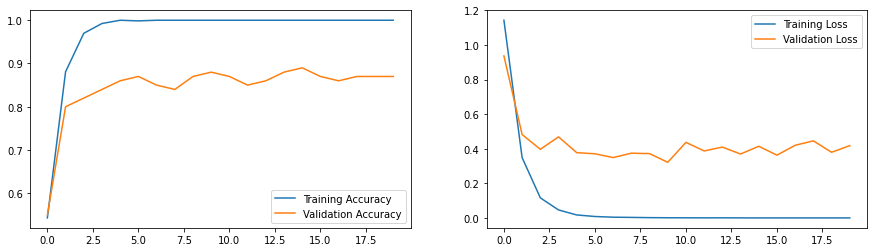

In [17]:
# sequence ids - selecting frames from 5 to 25.
seq_idx = range(5,25,1)

# image dimensions
dim_x, dim_y = 160, 160

# input shape for the first layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)

# Fetch pre-trained weights from mobile net v2
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(dim_x, dim_y, 3))

model_28_2 = Sequential([
    TimeDistributed(mobilenet, input_shape=input_shape)
])

# Freeze the weights of mobile net
for layer in model_28_2.layers:
    layer.trainable = False

# Add custom layers for required task
model_28_2.add(TimeDistributed(BatchNormalization()))
model_28_2.add(TimeDistributed(MaxPooling2D(pool_size=2)))

# Flatten the output from pre-trained model
model_28_2.add(TimeDistributed(Flatten()))

# RNN layer
model_28_2.add(GRU(256))
model_28_2.add(Dropout(0.2))

# Dense networks to classify the input
model_28_2.add(Dense(256,activation='relu'))
model_28_2.add(Dropout(0.2))
model_28_2.add(Dense(num_classes, activation='softmax'))

# Build and train the above model
build_and_train_model(model_28_2, name='model_28_2', image_height=dim_y, image_width=dim_x, img_idx=seq_idx, batch_size=batch_size)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 15 | 
| Training Accuracy   | 1.0  | Training Loss     | 0.00072 |
| Validation Accuracy | 0.89 | Validation Loss   | 0.41466 |

> - The model is giving **good** results similar to model_28.

---

### Experiment 38:

- Experiment on model_28 by increasing the number of frames to 20 and the image dimensions to 128 which is one of the standard imagenet weight input shape.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_23 (TimeDi  (None, 20, 4, 4, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 20, 4, 4, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 20, 2, 2, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 20, 5120)         0         
 stributed)                                                      
                                                                 
 gru_5 (GRU)                 (None, 256)              

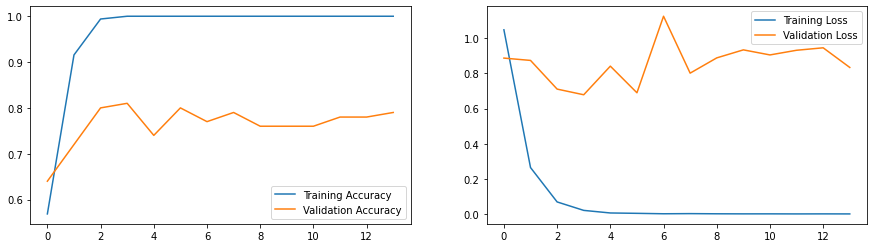

In [19]:
# sequence ids - selecting frames from 5 to 25.
seq_idx = range(5,25,1)

# image dimensions
dim_x, dim_y = 128, 128

# input shape for the first layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)

# Fetch pre-trained weights from mobile net v2
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(dim_x, dim_y, 3))

model_28_3 = Sequential([
    TimeDistributed(mobilenet, input_shape=input_shape)
])

# Freeze the weights of mobile net
for layer in model_28_3.layers:
    layer.trainable = False

# Add custom layers for required task
model_28_3.add(TimeDistributed(BatchNormalization()))
model_28_3.add(TimeDistributed(MaxPooling2D(pool_size=2)))

# Flatten the output from pre-trained model
model_28_3.add(TimeDistributed(Flatten()))

# RNN layer
model_28_3.add(GRU(256))
model_28_3.add(Dropout(0.2))

# Dense networks to classify the input
model_28_3.add(Dense(256,activation='relu'))
model_28_3.add(Dropout(0.2))
model_28_3.add(Dense(num_classes, activation='softmax'))

# Build and train the above model
build_and_train_model(model_28_3, name='model_28_3', image_height=dim_y, image_width=dim_x, img_idx=seq_idx, batch_size=batch_size)

#### Inference:

| Parameter | Best Value | | |
|:----------|:------|:---|:--|
| Epoch | 4 | 
| Training Accuracy   | 1.0  | Training Loss     | 0.02165 |
| Validation Accuracy | 0.81 | Validation Loss   | 0.67828 |

> - The metrics are good, but it is **not** better than model_28.

---
<a id='additional_overall_inference'></a>
## Overall inference:

> - From additional experiments, model_28_2 (Experiment 37) is giving good results, but we can **ignore** this model, since model_28 with *lesser image resolution* and *lesser number of frames* was able to provide similar results.
> - Hence, additional experiments **did not** give any better model.

---
---
<a id='conclusion'></a>
## Conclusion

From the above experiments and **38** different models built on different architectures, below are the good models from each variant,

| Model | Architecture | Total Parameters | Weight file size | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss |
|:--|:--|:--|:--|:--|:--|:--|:--|
| model_8 | Conv3D | 87,429 | 1090 KB | 0.73152 | 0.63 | 0.64653 | 0.93146 |
| model_15| Conv2D + RNN | 225,477 | 2700 KB | 0.84804 | 0.82 | 0.34843 | 0.48902 |
| model_23| Conv2D + RNN | 13,781 | 254 KB | 0.75603 | 0.75 | 0.62860 | 0.67698 |
| **model_28** | **Transfer learning + RNN** | **3,511,365** | **23.3 MB** | **1.0** | **0.88** | **0.00159** | **0.34987** |

> - *We can ignore model_8 as we have better models from other variants*

> - Each model is good in different use cases, as few shown below,

| Memory Availability  | Performance Needed | Suggested model |
|:--|:--|:--|
| Abundant | High        | model_28 |
| Abundant | Moderate    | model_28 or model_15 |
| Moderate | Moderate    | model_15 |
| Less     | Moderate    | model_23 |

> - For the assignment purpose, we can consider **model_28** with the above shown metrics as the **best** model.

---
<a id='load_and_test'></a>
### Load and test the best model:

In [25]:
# Load the best model, make sure to check the model name and place it in the same folder level
best_model = load_model('model-00015-0.00159-1.00000-0.34987-0.88000.h5')

Source path =  /home/datasets/Project_data/val ; batch size = 10


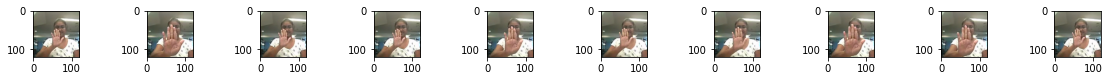

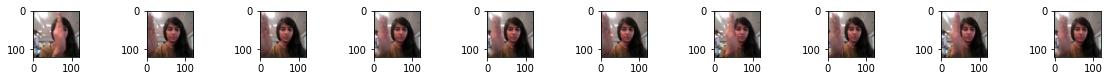

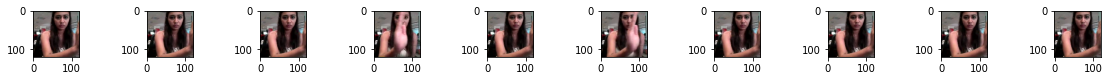

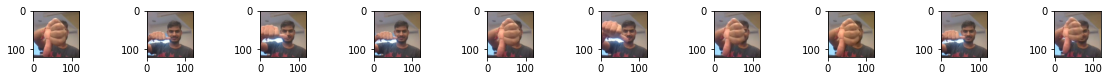

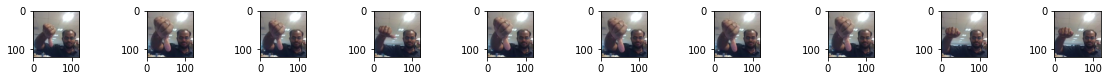

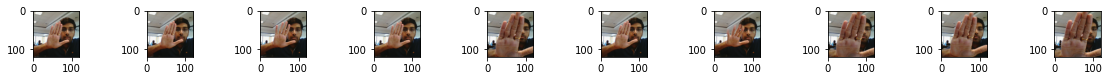

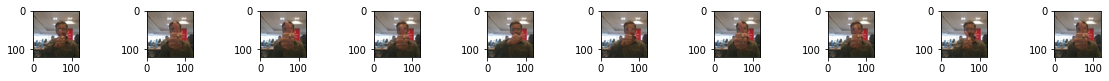

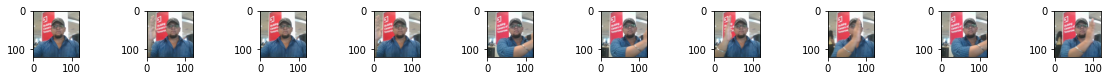

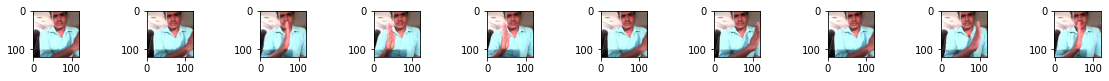

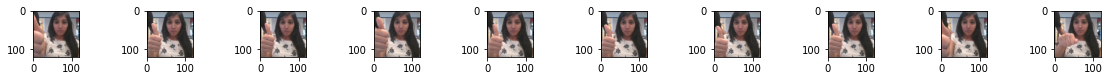

In [41]:
# Build a generator and fetch 10 sample test data from validation folder
sample_test_data = generator(val_path, val_doc, 10)
batch_data, batch_labels = next(sample_test_data)

# Plot the yielded batch
for idx in range(0,len(batch_data)):
    plt.figure(figsize=(20, len(batch_data[idx])))
    pos = 1
    for n in range(0,len(batch_data[idx])):
        plt.subplot(len(batch_data), len(batch_data[idx]), pos)
        plt.imshow(batch_data[idx][n])
        pos = pos+1
    plt.pause(2)

In [42]:
# Acutal labels for the above batch
actual_labels = np.argmax(batch_labels, axis=1)
print('Actual labels :', actual_labels)

Actual labels : [2 0 1 3 3 2 4 0 1 4]


In [43]:
# Predict the labels for the above batch
predicted_labels = np.argmax(best_model.predict(batch_data[:,:,:,:,:]),axis=1)
print('Predicted labels :',predicted_labels)

Predicted labels : [2 0 1 3 3 2 4 1 1 4]


In [46]:
# Accuracy of the prediction
accuracy = (np.sum(np.equal(actual_labels, predicted_labels))/len(actual_labels)) * 100
print('Acccuracy of the prediction : ', accuracy, '%')

Acccuracy of the prediction :  90.0 %


---
---